# MinD Oscillations in E. coli

One spatial reaction-diffusion system that has been studied frequently in the literature both in a deterministic setting (Huang et. al, 2003) and using a stochastic description (Fange and Elf, 2006) is describing the periodic oscillations of Min proteins in the bacterium E. Coli. By oscillating from pole to pole, MinC suppresses the formation of a cell division site at the poles, indirectly positioning it in the middle of the cell.

References:
 - Kerwyn Casey Huang, Yigal Meir, and Ned S. Wingreen, Dynamic structures in Escherichia coli: Spontaneous formation of MinE rings and MinD polar zones,PNAS, 2003.
 - David Fange and Johan Elf, Noise-induced Min Phenotypes in E. Coli, PLOS Computational Biology, 2(6), 2006.

### Imports and definitions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt

import spatialpy

In [2]:
class DomainSize(spatialpy.DataFunction):
    def __init__(self, domain):
        spatialpy.DataFunction.__init__(self, name="DomainSize")
        self.domain = domain
        self.h = domain.get_domain_size()
    
    def map(self, point):
        ret = self.h[self.domain.closest_vertex(point)]
        return ret

### Model

In [3]:
class mincde(spatialpy.Model):
    """ Model of MinD oscillations in E. Coli, based on the model by Huang. et. al. in """
    CYTOSOL = "Cytosol"
    MEMBRATE = "Membrate"

    def __init__(self,model_name="mincde"):
        spatialpy.Model.__init__(self, model_name)

        # Domain
        domain = spatialpy.Domain.read_msh_file("Domain_Files/coli.msh")
        domain.set_properties(spatialpy.GeometryInterior(), self.CYTOSOL)
        domain.set_properties(spatialpy.GeometryExterior(), self.MEMBRATE)
        self.add_domain(domain)

        D_m = 1e-14
        D_c = 2.5e-12

        # Species
        # Restrict to membrane protiens to membrane domain (2)
        MinD_m = spatialpy.Species(name="MinD_m", diffusion_coefficient=D_m, restrict_to=self.MEMBRATE)
        MinD_c_atp = spatialpy.Species(name="MinD_c_atp", diffusion_coefficient=D_c)
        MinD_c_adp = spatialpy.Species(name="MinD_c_adp", diffusion_coefficient=D_c)
        MinD_e = spatialpy.Species(name="MinD_e", diffusion_coefficient=D_c)
        MinDE = spatialpy.Species(name="MinDE", diffusion_coefficient=D_m, restrict_to=self.MEMBRATE)
        self.add_species([MinD_m, MinD_c_atp, MinD_c_adp, MinD_e, MinDE])

        # Parameters
        sigma_d = spatialpy.Parameter(name="sigma_d", expression=2.5e-8)
        sigma_dD = spatialpy.Parameter(name="sigma_dD", expression=0.0016e-18)
        sigma_e = spatialpy.Parameter(name="sigma_e", expression=0.093e-18)
        sigma_de = spatialpy.Parameter(name="sigma_de", expression=0.7)
        sigma_dt = spatialpy.Parameter(name="sigma_dt", expression=1.0)
        self.add_parameter([sigma_d, sigma_dD, sigma_e, sigma_de, sigma_dt])
        
        # Data function (spatially varying constant)
        self.add_data_function(DomainSize(self.domain))

        # Reactions
        R1 = spatialpy.Reaction(propensity_function="MinD_c_atp * sigma_d / DomainSize", 
                                restrict_to=self.MEMBRATE,
                                reactants={MinD_c_atp:1}, products={MinD_m:1})
        R2 = spatialpy.Reaction(rate=sigma_dD,
                                reactants={MinD_c_atp:1,MinD_m:1}, products={MinD_m:2})
        R3 = spatialpy.Reaction(rate=sigma_e,
                                reactants={MinD_m:1,MinD_e:1}, products={MinDE:1})
        R4 = spatialpy.Reaction(rate=sigma_de,
                                reactants={MinDE:1}, products={MinD_c_adp:1,MinD_e:1})
        R5 = spatialpy.Reaction(rate=sigma_dt,
                                reactants={MinD_c_adp:1}, products={MinD_c_atp:1})
        R6 = spatialpy.Reaction(rate=sigma_dD,
                                reactants={MinDE:1,MinD_c_atp:1}, products={MinD_m:1,MinDE:1})
        self.add_reaction([R1, R2, R3, R4, R5, R6])
        
        # Initial Conditions
        self.add_initial_condition(spatialpy.ScatterInitialCondition(MinD_c_adp, 4500))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(MinD_e, 1575))

        #self.timespan(range(200), timestep_size=1)
        self.timespan(range(500), timestep_size=1)

In [4]:
model = mincde(model_name="mincde")

In [5]:
model.domain

## Running the model and processing the results

In [6]:
#%time result = model.run()
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 2.88 s, sys: 32.8 ms, total: 2.91 s
Wall time: 3.61 s
/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/spatialpy_build_ofctz8va


In [7]:
%time result = sol.run()

CPU times: user 2.08 ms, sys: 5.5 ms, total: 7.58 ms
Wall time: 2min 17s


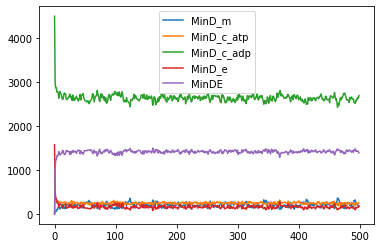

In [8]:
for s in result.model.get_all_species().keys():
    val = result.get_species(s)
    plt.plot(result.tspan, np.sum(val,axis=1), '-', label=s)
plt.legend()

# Analysis of 'result' object 

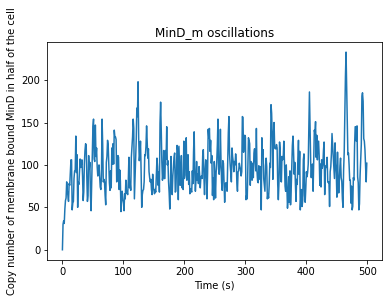

In [9]:
mindm = result.get_species("MinD_m")

y_vals = model.domain.coordinates()[:, 1]
idx = y_vals < 1e-6
mindmsum = np.sum(mindm[:,idx],axis=1)
plt.plot(result.tspan, mindmsum)
plt.title('MinD_m oscillations')
plt.xlabel('Time (s)')
_=plt.ylabel('Copy number of membrane bound MinD in half of the cell')

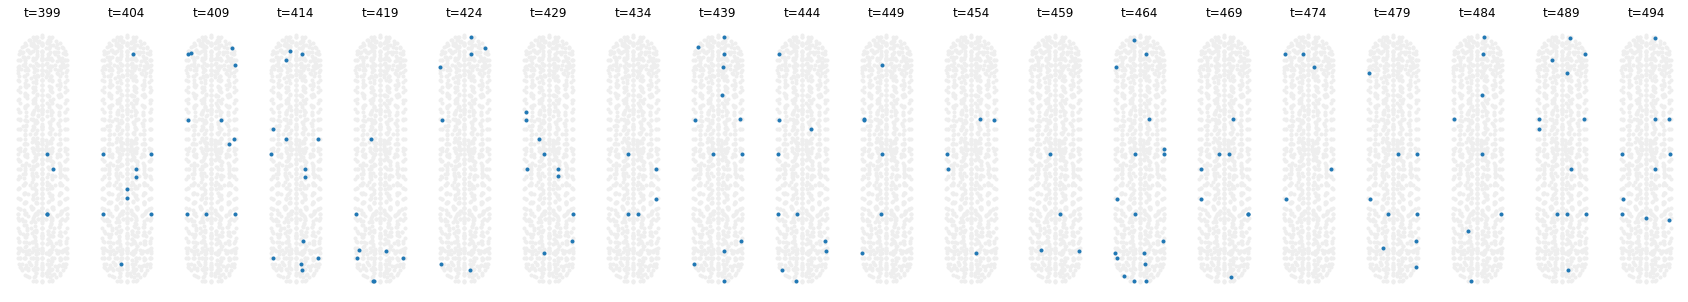

In [10]:
mx = np.max(mindmsum)
tmax = [i for i, j in enumerate(mindmsum) if j == mx][0]
tmax = min(tmax, int(result.tspan[-1]-100) )
# tlist = range(model.tspan[-1]-100,model.tspan[-1],10)
tlist = range(tmax, tmax+100, 5)
# plt.figure(figsize=(len(tlist)*0.75,2))
plt.figure(figsize=(len(tlist)*1.5, 5))
for num, tnow in enumerate(tlist):
    minD1 = result.get_species("MinD_m", tnow)
    xlist = []
    ylist = []
    zlist = []
    cutoff = 5
    for vndx, minD_val in enumerate(minD1):
        if minD_val > cutoff:
            c = model.domain.coordinates()[vndx,:]
            #print vndx, minD_val, c
            xlist.append(c[0])
            ylist.append(c[1])
            zlist.append(c[2])

    plt.subplot(1,len(tlist),num+1)
    plt.plot(model.domain.coordinates()[:,0], model.domain.coordinates()[:,1], '.', color='#eeeeee')
    plt.plot(xlist,ylist,'.')
    plt.title('t={0}'.format(tnow))
    plt.xlim(-3e-7, 3e-7)
    plt.ylim(-5e-7, 25e-6)
    plt.axis('equal')
    plt.axis('off')


In [11]:
result.plot_species("MinD_m",-1)

In [12]:
result.plot_property('type')